# Plant Disease Diagnosis with Gemma3n Vision Model

## Overview

This notebook demonstrates a comprehensive plant disease diagnosis system that combines:
- **Gemma3n Vision Model**: State-of-the-art multimodal model for image understanding
- **CNN Classification**: VisionTinyCNN with depth-wise convolutions for efficient disease classification
- **RAG (Retrieval-Augmented Generation)**: Expert knowledge retrieval using FAISS vector search
- **Mixed Precision Training**: Automatic precision selection (BF16/FP16) for optimal performance

The system provides accurate plant disease identification with detailed management recommendations by combining computer vision predictions with expert agricultural knowledge.

---

## 1. Setup and Dependencies

This section installs all required packages for the plant disease diagnosis system. The installation is optimized for CUDA environments and includes specific version constraints for compatibility.

In [1]:
# Clean up conflicting packages and install core dependencies
!pip uninstall -y pygobject gradient gradient-utils
!pip install --no-cache-dir --upgrade packaging==24.2
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft==0.16.0 trl triton cut_cross_entropy unsloth_zoo
!pip install --upgrade bitsandbytes
!pip install triton==3.2.0
!pip install pip3-autoremove

# Install PyTorch with CUDA support
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

# Install Unsloth for efficient model training
!pip install unsloth==2025.8.1

# Install RAG and search dependencies
!pip install faiss-cpu
!pip install sentence-transformers
!pip install wikipedia

# Install Transformers and related packages
!pip install transformers==4.53.3
!pip install --no-deps --upgrade timm

# Install DeepSpeed for distributed training (optional)
!pip uninstall -y deepspeed
!pip install deepspeed==0.14.4
!pip install tf-keras

# Upgrade sentence transformers
!pip install --upgrade sentence-transformers

Looking in indexes: https://download.pytorch.org/whl/cu124
Found existing installation: deepspeed 0.14.4
Uninstalling deepspeed-0.14.4:
  Successfully uninstalled deepspeed-0.14.4
  Using cached deepspeed-0.14.4-py3-none-any.whl


## 2. Model and Environment Configuration

### Technical Rationale:
- **CUDA_VISIBLE_DEVICES**: Restricts to single GPU for consistent performance
- **TORCH_COMPILE**: Disabled for compatibility with Unsloth optimizations
- **Mixed Precision**: Automatic selection between BF16 (if supported) and FP16 for optimal training speed and memory usage
- **4-bit Quantization**: Reduces VRAM usage by ~75% while maintaining model quality

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TORCH_COMPILE"] = "0"
os.environ["UNSLOTH_DISABLE_TORCH_COMPILE"] = "1" 

import json
import torch
import torch.nn as nn
import time
from PIL import Image
from tqdm import tqdm
from unsloth import FastModel, FastVisionModel
from unsloth.trainer import UnslothVisionDataCollator
from transformers import TextStreamer
from datasets import Dataset, Image as HFImage, load_dataset
import torch.nn.functional as F
from transformers import Trainer, TrainingArguments, AutoProcessor
from torch.utils.data import DataLoader
from transformers.modeling_outputs import SequenceClassifierOutput
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torchvision import transforms, datasets
import pandas as pd
import random

def get_amp_dtype() -> torch.dtype:
    """Automatically select optimal mixed precision dtype based on GPU capabilities"""
    return torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

amp_dtype = get_amp_dtype()
print(f"🔧 Using mixed precision dtype: {amp_dtype}")

# Dataset configuration
base_dir = '/notebooks/kaggle/input/new_plant_diseases/2/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'

# Load Gemma3n vision model with 4-bit quantization
print("🔧 Loading Gemma3n vision model with 4-bit quantization...")
llm_model, tokenizer = FastVisionModel.from_pretrained(
    model_name="unsloth/gemma-3n-E2B-it",
    dtype=None,  # Default precision (optimized by Unsloth)
    max_seq_length=1024,
    load_in_4bit=True,  # 4-bit quantization for memory efficiency
    full_finetuning=False,
)
print("✅ Model loaded successfully")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-08-05 16:08:57.241456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754410137.256551    3386 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754410137.260952    3386 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754410137.272564    3386 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754410137.272564    3386 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754410137.272564    3386 computation_placer.cc:177] computation placer alr

🦥 Unsloth Zoo will now patch everything to make training faster!
🔧 Using mixed precision dtype: torch.bfloat16
🔧 Loading Gemma3n vision model with 4-bit quantization...
==((====))==  Unsloth 2025.8.1: Fast Gemma3N patching. Transformers: 4.53.3.
   \\   /|    NVIDIA RTX A6000. Num GPUs = 1. Max memory: 44.547 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3N does not support SDPA - switching to eager!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Model loaded successfully


## 3. Dataset Loading and Processing

### Dataset Architecture:
The system loads plant disease images from a structured directory format:
```
base_dir/
├── train/
│   ├── Apple___Apple_scab/
│   ├── Potato___Early_blight/
│   └── ...
└── valid/
    ├── Apple___Apple_scab/
    └── ...
```

### Processing Strategy:
- **Path-based loading**: Images are stored as file paths for memory efficiency
- **Validation subset**: Limited to 200 samples for faster evaluation
- **Class mapping**: Consistent integer encoding across train/validation splits

In [3]:
# Data loading using existing train/valid split
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')

print("📊 Loading dataset...")

def load_dataset_from_dir(root_dir):
    """Load dataset from directory structure with file counting"""
    classes = []
    paths = []
    class_file_counts = {}
    
    for dirname, _, filenames in os.walk(root_dir):
        class_name = dirname.split('/')[-1]
        if class_name == os.path.basename(root_dir):  # Skip root directory
            continue
            
        if class_name not in class_file_counts:
            class_file_counts[class_name] = 0
        
        for filename in filenames:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                full_path = os.path.join(dirname, filename)
                if os.path.exists(full_path):
                    classes.append(class_name)
                    paths.append(full_path)
                    class_file_counts[class_name] += 1
    
    return classes, paths, class_file_counts

# Load train and validation datasets
train_classes, train_paths, train_counts = load_dataset_from_dir(train_dir)
val_classes, val_paths, val_counts = load_dataset_from_dir(valid_dir)

# Get unified class names from ImageFolder for consistency
train_dataset_folder = datasets.ImageFolder(root=train_dir)
class_names = train_dataset_folder.classes
print(f"Class names: {class_names}")
print(f"Number of classes: {len(class_names)}")

# Dataset processing for vision classification
def process_vision_dataset(paths, classes, class_names, dataset_name):
    """Process dataset for vision classification (image path and class ID pairs)"""
    processed_dataset = []
    normal_mapping = {cls: idx for idx, cls in enumerate(class_names)}
    
    for path, class_name in zip(paths, classes):
        class_id = normal_mapping[class_name]
        
        processed_dataset.append({
            "image": path,  # Store image path for lazy loading
            "labels": class_id  # Class ID (int)
        })

    return processed_dataset

# Create dataset
print("📊 Creating vision datasets...")
train_ds = process_vision_dataset(train_paths, train_classes, class_names, "training")
val_ds = process_vision_dataset(val_paths, val_classes, class_names, "validation")

# Limit validation set for faster evaluation
random.seed(3407)
val_ds = random.sample(val_ds, min(200, len(val_ds)))

print(f"✅ Converted {len(train_ds)} training samples for vision classification")
print(f"✅ Converted {len(val_ds)} validation samples for vision classification")

# Show sample from vision dataset
print("\n📋 Sample vision dataset entry:")
print(f"Image type: {type(train_ds[0]['image'])}")
print(f"Label: {train_ds[0]['labels']} (class: {class_names[train_ds[0]['labels']]})")

📊 Loading dataset...
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted

## 4. Vision Model Architecture

### VisionTinyCNN Design Rationale:

**Architecture Components:**
1. **Frozen Vision Tower**: Pre-trained Gemma3n vision features (2048-dim) are frozen to preserve learned representations
2. **Efficient Conv Head**: 
   - 1×1 convolution reduces dimensions from 2048→256 (87% parameter reduction)
   - Depth-wise 3×3 convolution for spatial feature learning
   - BatchNorm + SiLU activation for training stability
3. **Global Pooling**: AdaptiveAvgPool2d for translation invariance
4. **Classification Head**: Single linear layer for disease classification

**Mixed Precision Integration:**
- Vision tower inference uses `amp_dtype` (BF16/FP16) for memory efficiency
- Classification head remains in FP32 for numerical stability

In [4]:
class VisionTinyCNN(nn.Module):
    def __init__(self, vision_model, num_classes, hidden=2048):
        super().__init__()
        self.vision_model = vision_model  # Frozen Gemma3n vision tower
        
        # Efficient convolutional head with depth-wise convolutions
        self.conv_head = nn.Sequential(
            nn.Conv2d(hidden, 256, 1, bias=False),  # 1x1 dimension reduction
            nn.BatchNorm2d(256),
            nn.SiLU(),
            nn.Conv2d(256, 256, 3, padding=1, groups=256),  # Depth-wise convolution
            nn.BatchNorm2d(256),
            nn.SiLU(),
        )
        self.pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling
        self.fc = nn.Linear(256, num_classes)  # Classification head

    def forward(self, pixel_values):
        # Vision tower inference with mixed precision and gradient isolation
        with torch.no_grad(), torch.amp.autocast('cuda', dtype=amp_dtype):
            x = self.vision_model(pixel_values.to(amp_dtype)).last_hidden_state
        
        # Classification head (trainable)
        x = self.conv_head(x)                # (B,256,H,W)
        x = self.pool(x).flatten(1)          # (B,256)
        return self.fc(x)

# Unified prediction result function
def predict_with_labels(logits, k=3, class_names_list=None):
    """Unified function to get Top-K predictions with class names and probabilities from logits
    
    Args:
        logits (torch.Tensor): Model output logits (tensor or single prediction)
        k (int): Number of top predictions to retrieve (default 3)
        class_names_list (list, optional): List of class names
    
    Returns:
        list: [{'class_name': str, 'confidence': float}, ...] 
    """
    
    # Convert 1D logits (single sample) to 2D
    single_prediction = False
    if len(logits.shape) == 1:
        logits = logits.unsqueeze(0)
        single_prediction = True
    
    # Convert to probabilities and get Top-K
    probs = torch.softmax(logits, dim=-1)
    top_k_probs, top_k_ids = torch.topk(probs, k, dim=-1)
    
    results = []
    for i in range(len(top_k_ids)):
        predictions = []
        for j in range(k):
            class_id = top_k_ids[i][j].item()
            confidence = top_k_probs[i][j].item()
            class_name = class_names_list[class_id]
            predictions.append({
                'class_name': class_name,
                'confidence': confidence
            })
        results.append(predictions)
    
    # Return direct list for single prediction
    return results[0] if single_prediction else results
    
def compute_metrics(eval_pred):
    """Compute accuracy metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

print("✅ VisionTinyCNN architecture defined")

✅ VisionTinyCNN architecture defined


## 5. Data Collation and Processing

### VisionDataCollator Technical Design:

**Lazy Loading Strategy:**
- Images are loaded from disk only when needed (during batch creation)
- Reduces RAM usage for large datasets
- Enables efficient dataset shuffling and sampling

**Image Processing Pipeline:**
1. **PIL Loading**: Load images as PIL objects for compatibility
2. **RGB Conversion**: Ensure consistent 3-channel format
3. **Processor Integration**: Use Gemma3n's native image processor
4. **Tensor Stacking**: Efficient batch tensor creation

**Memory Optimization:**
- Batch-wise processing minimizes peak memory usage
- Compatible with gradient accumulation for larger effective batch sizes

In [5]:
# Custom trainer class for CNN classification
class CNNTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_grad_norm = 1.0  # Gradient clipping norm
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """Custom loss computation for CNN classification"""
        logits = model(inputs['pixel_values'])
        loss = F.cross_entropy(logits, inputs['labels'])
        
        return (loss, logits) if return_outputs else loss
    
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        """Custom prediction step for evaluation"""
        pixel_values = inputs.get('pixel_values')
        labels = inputs.get('labels')
        
        with torch.no_grad():
            logits = model(pixel_values)
            loss = F.cross_entropy(logits, labels)
        
        return (loss, logits, labels)

# Initialize processor for image preprocessing
processor = AutoProcessor.from_pretrained(
    "unsloth/gemma-3n-E2B-it",
    trust_remote_code=True
)
    
# Data collator for vision classification with lazy loading
class VisionDataCollator:
    def __init__(self, processor):
        self.processor = processor
    
    def __call__(self, batch):
        """Process batch of image paths and labels into tensors"""
        image_paths = [item["image"] for item in batch]  # Image paths
        labels = torch.tensor([item["labels"] for item in batch], dtype=torch.long)
        
        # Process image paths with lazy loading
        pixel_values = []
        for image_path in image_paths:
            # Load PIL Image from path
            image = Image.open(image_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')
            
            # Process through Gemma3n processor
            processed = self.processor(
                text="dummy",  # Dummy text for multimodal processor
                images=image,  # PIL Image object
                return_tensors="pt"
            )
            pixel_values.append(processed["pixel_values"].squeeze(0))
        
        pixel_values = torch.stack(pixel_values)
        
        return {
            "pixel_values": pixel_values,
            "labels": labels
        }

print("✅ Data collator and trainer classes defined")

✅ Data collator and trainer classes defined


## 6. Model Training Setup

### Training Configuration Rationale:

**Memory Optimization:**
- **Batch Size**: 8 per device with 8x gradient accumulation = effective batch size 64
- **Mixed Precision**: FP16 training reduces memory usage by ~50%
- **Frozen Vision Tower**: Only train classification head (~1M parameters vs 3B+ total)

**Training Dynamics:**
- **Learning Rate**: 1e-3 for CNN head (higher than typical fine-tuning)
- **Linear Schedule**: Gradual learning rate decay for stable convergence
- **Early Stopping**: Save best model based on validation accuracy
- **Gradient Clipping**: Prevent gradient explosion in mixed precision training

**Efficiency Considerations:**
- **Max Steps**: 100 steps for rapid prototyping (increase for production)
- **Evaluation Strategy**: Every 20 steps for frequent monitoring
- **Logging**: Every 10 steps for detailed training insights

In [6]:
from peft import LoraConfig, get_peft_model, TaskType

# Initialize vision model components
vision_tower = llm_model.model.vision_tower
vision_tower.eval()  # Freeze vision tower
vision_tower.requires_grad_(False)  # Disable gradients for memory efficiency

# Create VisionTinyCNN model
vis_model = VisionTinyCNN(vision_tower, num_classes=len(class_names)).to("cuda")

# Training arguments optimized for plant disease classification
args = TrainingArguments(
    output_dir="cnn_ckpt",
    
    # Batch size configuration
    per_device_train_batch_size=8,  # Base batch size
    per_device_eval_batch_size=16,  # Larger eval batch for efficiency
    gradient_accumulation_steps=8,  # Effective batch size = 8 * 8 = 64
    
    # Training schedule
    warmup_steps=5,
    num_train_epochs=1,
    max_steps=100,  # Rapid prototyping (increase for production)
    
    # Optimization
    learning_rate=1e-3,  # Higher LR for CNN head training
    lr_scheduler_type='linear',
    max_grad_norm=1.0,  # Gradient clipping for stability
    
    # Mixed precision training
    bf16=False,  # Use FP16 instead of BF16
    fp16=True,   # Enable FP16 for memory efficiency
    
    # Data handling
    remove_unused_columns=False,  # Keep all columns for custom collator
    
    # Evaluation and saving
    eval_strategy="steps",
    eval_steps=20,
    save_strategy="steps",
    save_steps=20,
    logging_steps=10,
    
    # Model selection
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True, 
    
    # Experiment tracking
    report_to="none",  # Disable W&B for this demo
    run_name="gemma3n-plant-cnn-finetuning",
)

# Initialize trainer
trainer = CNNTrainer(
    model=vis_model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=VisionDataCollator(tokenizer),  # Use tokenizer as processor
    compute_metrics=compute_metrics,
)

print("✅ Training setup complete")
print(f"📊 Training samples: {len(train_ds)}")
print(f"📊 Validation samples: {len(val_ds)}")
print(f"🏷️ Number of classes: {len(class_names)}")
print(f"🔧 Mixed precision: FP16")
print(f"🔧 Effective batch size: {args.per_device_train_batch_size * args.gradient_accumulation_steps}")

[2025-08-05 16:09:45,854] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.6
 [WARNING]  using untested triton version (3.2.0), only 1.0.0 is known to be compatible


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/local/lib/python3.11/dist-packages/deepspeed/runtime/zero/linear.py:47: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @autocast_custom_fwd
/usr/local/lib/python3.11/dist-packages/deepspeed/runtime/zero/linear.py:66: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @autocast_custom_bwd


✅ Training setup complete
📊 Training samples: 70295
📊 Validation samples: 200
🏷️ Number of classes: 38
🔧 Mixed precision: FP16
🔧 Effective batch size: 64


## 7. Training Execution

### Training Process Overview:

This step executes the CNN classifier training using the frozen Gemma3n vision features. The training process:

1. **Forward Pass**: Images → Vision Tower (frozen) → CNN Head (trainable)
2. **Loss Computation**: Cross-entropy loss for multi-class classification
3. **Backward Pass**: Gradients only flow through CNN head parameters
4. **Optimization**: AdamW with gradient clipping and linear LR schedule
5. **Evaluation**: Accuracy-based model selection and checkpoint saving

**Expected Outcomes:**
- Training loss should decrease steadily
- Validation accuracy should improve over training steps
- Memory usage remains low due to frozen vision tower
- Training speed is fast due to efficient CNN architecture

In [7]:
# Execute training
print("🚀 Starting CNN classifier training...")
print("=" * 50)

trainer.train()

print("=" * 50)
print("✅ Training completed successfully!")
print(f"📁 Model saved to: {args.output_dir}")

🚀 Starting CNN classifier training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 70,295 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 537,638 of 294,664,550 (0.18% trained)


Step,Training Loss,Validation Loss,Accuracy
20,2.612900,2.056075,0.700000
40,1.689000,1.131390,0.870000
60,1.156400,0.770369,0.900000
80,0.921400,0.569770,0.930000
100,0.832600,0.496716,0.915000


✅ Training completed successfully!
📁 Model saved to: cnn_ckpt


## 8. Plant Disease Prediction Functions

### Prediction Pipeline Design:

**predict_plant_disease():**
- **Input**: PIL Image, trained vision model, processor
- **Processing**: RGB conversion → Gemma3n processor → CNN inference
- **Output**: Top-3 predictions with confidence scores

**generate_response():**
- **Purpose**: Common interface for LLM text generation
- **Features**: Configurable temperature, top-p sampling, token limits
- **Integration**: Used for both query generation and final responses

**Key Technical Features:**
- **Mixed Precision**: Consistent dtype handling across inference pipeline
- **Error Handling**: Robust image format conversion and validation
- **Memory Efficiency**: No gradient computation during inference

In [8]:
import json
import re
from typing import Any, Dict, List

def predict_plant_disease(image, vision_model, processor, class_names_list=None):
    """Predict plant disease with CNN model and return class names with probabilities"""
    # Ensure RGB format
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Process image using same pipeline as training
    processed = processor(
        text="dummy",  # Dummy text for multimodal processor
        images=image,
        return_tensors="pt"
    )
    pixel_values = processed["pixel_values"].to('cuda')
    
    vision_model.eval()
    
    # Inference with no gradient computation
    with torch.no_grad():
        logits = vision_model(pixel_values)
    
    # Get Top-3 predictions with confidence scores
    predictions = predict_with_labels(logits, k=3, class_names_list=class_names_list)
    
    return predictions

def generate_response(messages, max_new_tokens=128, temperature=0.7, top_p=0.9):
    """Common function for generating responses from Gemma3n model"""
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    ).to("cuda")
    
    generation_kwargs = {
        "max_new_tokens": max_new_tokens,
        "temperature": temperature,
        "top_p": top_p,
        "do_sample": True,
        "pad_token_id": tokenizer.eos_token_id,
    }
    
    with torch.no_grad():
        outputs = llm_model.generate(**inputs, **generation_kwargs)
    
    # Extract only the generated response (exclude input prompt)
    response_tokens = outputs[0][inputs['input_ids'].shape[1]:]
    response = tokenizer.decode(response_tokens, skip_special_tokens=True)
    
    return response

print("✅ Prediction functions defined")

✅ Prediction functions defined


## 9. Query Generation System

### LLM-based Query Generation Architecture:

**Design Philosophy:**
This system uses the Gemma3n model to intelligently convert natural language questions into structured search queries. The approach combines:

1. **Vision Predictions**: CNN model results provide disease context
2. **User Intent**: Natural language question analysis
3. **Domain Knowledge**: Plant disease expertise embedded in prompts
4. **Structured Output**: JSON format for reliable parsing

**Technical Implementation:**
- **Prompt Engineering**: Structured template with examples and constraints
- **JSON Parsing**: Robust parsing with error handling for malformed responses
- **Multi-query Strategy**: Generate 5 diverse queries for comprehensive search
- **Plant Relevance**: Built-in classification to filter non-plant queries

**Query Generation Benefits:**
- **Semantic Understanding**: Goes beyond keyword matching
- **Context Awareness**: Incorporates CNN predictions for precision
- **Expandable**: Easy to add new query types and domains

In [9]:
# Query generation prompt template with structured output
QUERY_GENERATION_PROMPT = """
# System
You are a plant disease expert and search query generation bot.

# Image Analysis Result (CNN Model Prediction)
Image analysis result: {image_predictions}

# Instructions
1. Based on the above image analysis results (disease diagnosis), convert user's natural language questions or images into suitable database search queries.
2. Utilize CNN model prediction results (disease names and probabilities) to generate more precise and specific queries.
3. Determine whether these queries are plant-related.

# Output Format
## Important: Output only valid JSON

## Exact Format:
{{
  "query": ["<query1>", "<query2>", "<query3>", "<query4>", "<query5>"],
  "is_plant": "<yes or no>"
}}

Examples:
Image analysis result: [[{{"class_name": "Tomato___Early_blight", "confidence": 0.85}}, {{"class_name": "Tomato___healthy", "confidence": 0.12}}]]
User input: "What is this plant disease?"
Correct output: {{"query":["tomato early blight","tomato disease diagnosis","plant blight symptoms","tomato leaf spots"],"is_plant":"yes"}}

User input: "What's the weather like today?"
Correct output: {{"query":["weather today","current weather"],"is_plant":"no"}}

"""

def generate_search_query(text, image, vision_predictions):
    """Generate search query from user natural language input with CNN prediction integration"""
    
    # Embed CNN prediction results into prompt
    prompt_with_predictions = QUERY_GENERATION_PROMPT.format(
        image_predictions=vision_predictions if vision_predictions else "No analysis results"
    )

    messages = [
        {
            "role": "system",
            "content": [
                {"type": "text", "text": prompt_with_predictions}
            ]
        },
        {
            "role": "user", 
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": text}
            ]
        }
    ]
    
    # Generate query with low temperature for consistency
    query = generate_response(
        messages=messages,
        max_new_tokens=512,
        temperature=0.1,  # Low temperature for structured output
        top_p=0.9
    ).strip()

    parsed_query = safe_json_loads(query)
    
    return parsed_query

def safe_json_loads(raw: str) -> Dict[str, Any]:
    """Robust JSON parsing with error handling for LLM outputs"""
    cleaned = raw.strip()

    # Remove markdown code blocks if present
    if cleaned.startswith("""`"""):
        cleaned = re.sub(r"^```[a-z]*\n?", "", cleaned, flags=re.IGNORECASE)
        cleaned = re.sub(r"\n?```$", "", cleaned).strip()

    # Remove trailing commas (common LLM error)
    cleaned = re.sub(r",\s*([}\]])", r"\1", cleaned)
    
    try:
        data = json.loads(cleaned)
        return data
    except json.JSONDecodeError as e:
        print(f"⚠️ JSON parsing error: {e}")
        print(f"Raw output: {raw[:200]}...")
        # Return fallback structure
        return {"query": ["plant disease"], "is_plant": "yes"}

print("✅ Query generation system defined")

✅ Query generation system defined


## 10. RAG Knowledge Base

### Expert Knowledge Database Design:

**Content Structure:**
The knowledge base contains expert-curated information for 9 major plant diseases:
- Apple: Scab, Black Rot, Cedar Apple Rust
- Corn: Northern Leaf Blight, Gray Leaf Spot, Common Rust  
- Grape: Black Rot, Esca (Black Measles)
- Potato: Early Blight
- Cherry: Powdery Mildew

**Information Categories:**
1. **Symptoms**: Visual identification features
2. **Disease Cycle**: Pathogen lifecycle and spread mechanisms
3. **Management**: Cultural practices, resistant varieties, chemical control
4. **Prevention**: Proactive strategies and best practices

**Technical Implementation:**
- **Chunking Strategy**: 512-character chunks with 64-character overlap
- **Metadata Preservation**: Class names and IDs for traceability
- **Semantic Compatibility**: Optimized for sentence transformer embeddings

In [10]:
import os, glob, json, faiss, numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

# RAG configuration
CHUNK_SIZE = 512
CHUNK_OVERLAP = 64

# Expert knowledge base with comprehensive plant disease information
RAG_DATABASE = [
  {
    "id": "apple_scab_001",
    "class_name": "apple_apple_scab",
    "context": "Apple scab is a common and serious fungal disease affecting apple and crabapple trees. It is caused by the fungus *Venturia inaequalis*. The disease thrives in cool, moist conditions, especially during spring and early summer.\n\n### Symptoms\n\nThe most common signs of apple scab appear on leaves and fruit:\n\n*   **On Leaves:** The first symptoms in spring are often small, velvety, olive-green spots on the undersides of new leaves. These spots eventually darken to a brown or black color and may feel rough or velvety. Infected leaves can become distorted, curled, yellow, and drop prematurely.\n*   **On Fruit:** Infections on young fruit also start as olive-green to black, circular spots. As the fruit develops, these spots become brown, rough, and corky, sometimes causing the fruit to become misshapen and crack. Early infections can cause young fruit to drop. Late-season infections might not be visible at harvest but can develop in storage.\n*   **On Blossoms and Twigs:** The fungus can also infect blossoms, causing them to drop, as well as other parts of the tree like petioles (leaf stems).\n\n### Disease Cycle\n\nThe apple scab fungus overwinters in fallen, infected leaves on the orchard floor. In the spring, during cool, wet weather, fungal spores (ascospores) are released from these dead leaves and are carried by wind and rain to newly emerging leaves and blossoms, starting the primary infection. About 9 to 17 days after infection, these new spots produce a different type of spore (conidia) that can cause secondary infections throughout the summer, especially during rainy periods.\n\n### Management\n\nA combination of cultural practices and chemical control is necessary for effective apple scab management.\n\n#### Cultural Practices:\n\n*   **Sanitation:** Raking and destroying fallen leaves in the autumn or early spring is crucial as it reduces the number of overwintering fungal spores.\n*   **Resistant Cultivars:** Planting scab-resistant apple varieties is an effective long-term management strategy."
  },
  {
    "id": "apple_black_rot_rag_001",
    "class_name": "Apple___Black_rot",
    "context": "Apple Black rot, caused by the fungus *Diplodia seriata* (*Botryosphaeria obtusa*), presents with distinct symptoms on fruit, leaves, and woody tissues, and can be managed through a combination of cultural practices and fungicide applications.\n\nSymptoms:\n*   Fruit: Initial infection on young fruits appears as small, raised purplish lesions. As the fruit ripens, these develop into large, brown, firm lesions that can eventually rot the entire fruit.\n*   Leaves (Frog-eye leaf spot): Symptoms on leaves begin as reddish-brown flecks. These flecks enlarge into circular brown lesions, often surrounded by a purple halo, which can lead to leaf yellowing (chlorosis) and premature leaf drop (abscission).\n*   Cankers: The fungus can also cause cankers on woody tissues. Old cankers, dead shoots, and twig debris serve as sources of inoculum for the disease.\n\nManagement Guide:\nEffective management of Apple Black rot involves several strategies:\n*   Orchard Sanitation: Good orchard sanitation is crucial. This includes removing or thoroughly chopping prunings (e.g., with a flail mower to aid decomposition), removing mummified apples (diseased fruit remaining on the tree or ground), and pruning out dead wood from the trees.\n*   Fire Blight Management: Pruning out current-season shoots infected with fire blight is important because these can be colonized by the black rot pathogen and act as a source of inoculum during the same growing season.\n*   Fungicide Applications: Fungicides used in integrated pest management (IPM) programs can help control *D. seriata*. Specifically, treatments that include strobilurin-containing fungicides (such as Flint, Sovran, Pristine, Luna Sensation, and Merivon) have shown better control of frogeye leaf spot compared to DMI fungicides alone. Reducing primary inoculum on leaf litter on orchard floors, a practice essential for controlling apple scab, can also contribute to black rot management."
  },
  {
    "id": "corn_northern_leaf_blight_rag_001",
    "class_name": "Corn_(maize)___Northern_Leaf_Blight",
    "context": "Northern Corn Leaf Blight (NCLB) is a significant disease in maize production, causing substantial yield reductions, sometimes as high as 30-50% in severe cases.\n\nSymptoms and Identification:\nNCLB primarily affects the corn plant's lamina (leaf blade), though it can also infect the sheath and bract. The disease typically manifests in the middle to later stages of growth, particularly after heading, when temperature and humidity are suitable. Resistant varieties may exhibit brown necrotic stripes along leaf veins with a yellow or hazel chlorotic round around them, producing few or no spores.\n\nManagement Strategies:\n*   Cultural Control:\n    *   Crop rotation with non-corn crops is an effective control method.\n    *   Avoiding planting corn next to small grains or fields with poor grass weed control in the previous year can help prevent issues.\n    *   Early planting can sometimes be beneficial.\n    *   Minimum tillage systems or moist conditions (rain or irrigation) can reduce damage from some pests, which might indirectly impact disease susceptibility.\n    *   Controlling winter annual vegetation (grass and weeds) two weeks before planting is important.\n*   Resistant Varieties: Using resistant varieties has been an effective control measure in the past.\n*   Chemical Control: While the provided information mentions chemical control for other corn issues like insects, it does not specifically detail chemical control for NCLB. However, the general concept of applying pesticides based on infection levels is mentioned in the context of plant disease detection."
  },
  {
    "id": "grape_black_rot_rag_001",
    "class_name": "Grape___Black_rot",
    "context": "Grape Black Rot, caused by the fungus *Guignardia bidwellii*, is a common and damaging disease of grapes, particularly in warm and humid climates. It can lead to significant crop losses if not managed effectively.\n\nSymptoms:\nBlack rot can affect all parts of the grapevine, including leaves, shoots, tendrils, and fruit.\n*   Leaves: Initial symptoms appear as small, yellowish spots that enlarge to form round, tan lesions with dark purple to brown margins. Tiny black dots, which are fungal fruiting bodies (pycnidia), may be visible within these lesions, sometimes arranged in a ring pattern. Severe infection can cause leaf deformity.\n*   Shoots, Petioles, and Tendrils: Lesions on these parts are typically oval, sunken, and purple to black. Black lesions can girdle petioles and shoots, leading to wilting.\n*   Fruit: Fruit symptoms usually appear when grapes are half-grown or pea-sized. Small, light brownish spots form on the berries, which then soften and become sunken. The entire berry quickly rots, shrivels, and turns into hard, black, wrinkled structures called \"mummies,\" which are dotted with pycnidia.\n\nManagement:\nEffective management of grape black rot involves a combination of cultural practices and chemical control.\n\nCultural/Biological Management:\n*   Sanitation: This is the most crucial aspect of black rot management.\n    *   Remove and destroy infected canes, spurs, and fruit clusters (mummies) from the vines.\n    *   Rake up and dispose of fallen leaves and mummies from the vineyard floor.\n    *   Mulch can be used to bury mummies, preventing spores from reaching new grape tissues in the spring.\n*   Pruning: During dormant pruning, remove diseased tendrils and canes to reduce the amount of spores available for infection in the spring.\n*   Site Selection and Air Circulation: Plant grapes in sunny, open areas with good air movement to help dry the plants more quickly, making them less susceptible to black rot. Good weed control is also important."
  },
  {
    "id": "potato_early_blight_rag_001",
    "class_name": "Potato___Early_blight",
    "context": "Potato Early Blight, caused by *Alternaria solani* and *Alternaria alternata*, is a significant disease affecting potato crops worldwide, leading to yield losses of 5-50%. It can damage both the foliage and tubers of potato plants.\n\nSymptoms:\n*   Foliage: Characteristic symptoms include dark brown to black lesions with concentric rings, creating a \"target spot\" effect. These lesions initially appear on older, senescing leaves. They enlarge, coalesce, and can eventually cause leaf death. Spores may be visible on older lesions under a microscope. Lesions can also develop on stems and petioles.\n*   Tubers: Infected tubers develop a dry rot, characterized by isolated, dark, irregular, sunken lesions on the surface. The diseased tissue under these lesions is dark brown, firm, and typically 10-12 mm deep.\n\nManagement:\nEffective management of potato early blight often involves an integrated disease management (IDM) approach, combining cultural practices, resistant cultivars, and fungicide applications.\n\n*   Cultural Practices:\n    *   Crop Rotation: A 3-5 year crop rotation with non-host crops is recommended.\n    *   Sanitation: Field sanitation, including the removal and burning of infected plant debris and eradication of weed hosts, helps reduce inoculum levels.\n    *   Planting Material: Using certified disease-free seed is crucial.\n    *   Nutrition and Water: Providing proper plant nutrition and avoiding water stress can help.\n    *   Volunteer Plants: Destruction of volunteer potato plants in nearby fields throughout the season and destruction of cull piles by freezing or deep burying can prevent disease spread.\n\n*   Resistant Cultivars: Utilizing resistant potato varieties is an important control strategy.\n\n*   Fungicide Application:\n    *   Fungicides are essential for managing early blight, especially under severe conditions.\n    *   Protectant fungicide spray programs are most effective when initiated early in the growing season.\n    *   Proper timing of initial and subsequent applications can reduce the overall frequency of sprays without significant yield loss. Predictive models can be used to time the first application.\n    *   Commonly used fungicides include azoxystrobin, boscalid, difenoconazole, mancozeb, and tebuconazole. Combinations like Azoxystrobin+Flutriafol have shown significant efficacy.\n    *   Ensuring good coverage, especially on lower, senescing leaves, is important during aerial application."
  },
  {
    "id": "apple_cedar_apple_rust_rag_001",
    "class_name": "Apple___Cedar_apple_rust",
    "context": "Cedar-apple rust is a fungal disease caused by *Gymnosporangium juniperi-virginianae*. It has a complex life cycle that requires two host plants: an apple or crabapple tree and a plant from the *Juniperus* genus (e.g., Eastern red cedar).\n\n### Symptoms\n\n*   **On Apple Leaves and Fruit:** The disease first appears in spring as small, pale yellow spots on the upper surfaces of leaves. These spots enlarge, turning a bright orange-yellow color, sometimes with a reddish border. Tiny black fungal bodies (spermogonia) may appear within the spots. Later in the season, distinctive tube-like structures called aecia form on the underside of the leaves, directly beneath the initial spots. Fruit infections are similar, appearing as large orange spots, which can cause the fruit to become deformed and drop prematurely.\n*   **On Cedar/Juniper Host:** On the juniper host, the fungus produces brown, kidney-shaped galls on twigs. In the spring of their second year, during wet weather, these galls swell and produce bright orange, gelatinous 'horns' (telial horns) that release spores to infect nearby apple trees.\n\n### Management\n\nEffective management requires interrupting the disease cycle.\n\n*   **Cultural Control:** The most effective strategy is to remove the alternate host. Eliminating all juniper trees within a one- to two-mile radius of the apple trees can prevent infection, though this is not always practical. Pruning out the cedar galls in late winter or early spring before they produce spores can also reduce the inoculum source.\n*   **Resistant Cultivars:** Planting apple varieties that are resistant to cedar-apple rust is a highly effective and recommended strategy.\n*   **Fungicide Applications:** Protective fungicides can be applied to apple trees to prevent infection. Sprays should begin at the pink bud stage and continue every 7-10 days until about two weeks after petal fall, especially during periods of high rainfall."
  },
  {
    "id": "cherry_powdery_mildew_rag_001",
    "class_name": "Cherry_(including_sour)___Powdery_mildew",
    "context": "Cherry powdery mildew is a fungal disease caused by *Podosphaera clandestina*. It affects leaves, shoots, and fruit, thriving in warm, humid conditions.\n\n### Symptoms\n\n*   **On Leaves:** The disease begins as light-green, circular lesions. These develop into the characteristic white, cotton-like patches of fungal growth. Severely infected leaves can become puckered, twisted, and distorted. Small, black fungal fruiting bodies (chasmothecia) may appear in the white patches later in the season.\n*   **On Fruit:** Fruit infections can be subtle, starting as circular, slightly depressed areas, sometimes with a faint white, powdery growth. The infection often begins near the stem. On ripe fruit, the mildew can appear as a white powdery bloom.\n\n### Management\n\nAn integrated approach is necessary for effective control.\n\n*   **Cultural Control:**\n    *   **Pruning:** Prune trees to improve air circulation and sunlight penetration, which helps reduce humidity.\n    *   **Irrigation:** Use irrigation methods that avoid wetting the foliage.\n    *   **Sucker Removal:** Remove root suckers, as they are highly susceptible to infection.\n    *   **Sanitation:** Rake and remove fallen leaves to reduce the overwintering fungal population.\n*   **Chemical Control:**\n    *   **Fungicides:** Preventative fungicide applications are crucial. A consistent spray program from shuck fall through harvest is often required.\n    *   **Resistance Management:** Rotate fungicides with different modes of action (FRAC groups) to prevent the fungus from developing resistance. Using pre-mixes with multiple modes of action can also be effective.\n    *   **Post-Harvest:** Applying materials like lime sulfur after harvest can help reduce the overwintering inoculum."
  },
  {
    "id": "corn_cercospora_gray_leaf_spot_rag_001",
    "class_name": "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "context": "Gray leaf spot (GLS) is a major fungal disease of corn caused by *Cercospora zeae-maydis* and *Cercospora zeina*. It is favored by warm, humid conditions and can cause significant yield loss.\n\n### Symptoms\n\n*   **Initial Lesions:** The first signs are small, tan or olive-green pinpoint spots, sometimes surrounded by a yellow halo. These typically appear on lower leaves first.\n*   **Mature Lesions:** The spots elongate into long, narrow, rectangular lesions that are pale brown to gray. A key characteristic is that the lesions are restricted by the leaf veins, giving them a distinct rectangular or 'matchstick' shape. They can be up to 2.5 inches long.\n*   **Severe Infection:** Under favorable conditions, the lesions can merge, leading to the death of entire leaves. The leaves may take on a grayish appearance due to the production of fungal spores.\n\n### Management\n\nAn integrated management approach is most effective.\n\n*   **Resistant Hybrids:** Planting corn hybrids with genetic resistance to GLS is the most important management strategy.\n*   **Crop Rotation:** Rotating to a non-host crop (e.g., soybeans, wheat) for at least one to two years helps reduce the fungal inoculum in the field, as the fungus overwinters in infected corn residue.\n*   **Residue Management:** Tillage practices that bury or break down corn residue can help reduce the survival of the fungus.\n*   **Fungicides:** Foliar fungicides can be effective, particularly for susceptible hybrids when applied early in the disease development, typically around the tasseling stage. Scouting is important to time applications correctly.\n*   **Cultural Practices:** Avoiding late planting and promoting good air circulation can help reduce disease severity."
  },
  {
    "id": "corn_common_rust_rag_001",
    "class_name": "Corn_(maize)___Common_rust_",
    "context": "Common rust in corn is caused by the fungus *Puccinia sorghi*. The disease is favored by cool, moist weather (61-77°F / 16-25°C). The fungus does not typically overwinter in the main corn-growing regions but its spores are carried north by wind from southern areas each year.\n\n### Symptoms\n\n*   **Pustules:** The most characteristic symptoms are small, oval or elongated, cinnamon-brown to brick-red powdery pustules. These pustules can appear on both the upper and lower surfaces of the leaves, as well as on stalks and husks.\n*   **Development:** The infection starts as small, chlorotic (yellowish) flecks on the leaves which then develop into the pustules. As the season progresses, these pustules may turn black.\n*   **Spores:** The reddish powder in the pustules is composed of fungal spores (urediniospores) that can be easily rubbed off.\n\n### Management\n\nWhile common rust is frequently observed, it rarely causes economic damage in modern hybrid corn.\n*   **Resistant Hybrids:** The primary and most effective management strategy is the use of resistant corn hybrids.\n*   **Fungicides:** Fungicide applications can be effective but are often not necessary for common rust alone. They may be considered if a susceptible hybrid is planted and disease pressure is unusually high early in the season.\n*   **Cultural Practices:** Because the disease is wind-borne and does not rely on local overwintering, practices like crop rotation and tillage are not effective for managing common rust."
  },
  {
    "id": "grape_esca_black_measles_rag_001",
    "class_name": "Grape___Esca_(Black_Measles)",
    "context": "Esca, also known as Black Measles, is a destructive grapevine trunk disease caused by a complex of wood-infecting fungi, primarily *Phaeomoniella chlamydospora* and species of *Phaeoacremonium*. The fungi infect vines through pruning wounds.\n\n### Symptoms\n\nEsca symptoms can be chronic or acute (apoplexy) and affect leaves, fruit, and the woody trunk.\n\n*   **Leaf Symptoms (Chronic):** A characteristic symptom is interveinal 'striping'. In red grape varieties, the stripes are dark red, while in white varieties, they are yellow or chlorotic. These stripes can dry out, and leaves may develop a 'tiger-stripe' pattern. Severely affected leaves may drop prematurely.\n*   **Fruit Symptoms (Chronic):** Berries can develop small, round, dark spots, often bordered by a brown-purple ring, giving them a 'measles' appearance. Affected berries may crack or fail to ripen properly.\n*   **Wood Symptoms:** A cross-section of an infected trunk or cordon reveals dark brown to black streaking or a pattern of dark spots in the vascular tissue (xylem). This is a sign of the internal wood decay.\n*   **Apoplexy (Acute):** This is a sudden collapse of the vine. A part of the vine or the entire plant may rapidly wilt and die, especially during hot summer weather.\n\n### Management\n\nManagement focuses on prevention as there is no cure once a vine is infected.\n\n*   **Pruning Practices:**\n    *   **Wound Protection:** This is the most critical step. Protect large pruning wounds with a wound sealant or paint containing a fungicide (e.g., thiophanate-methyl) to prevent fungal entry.\n    *   **Timing:** Avoid pruning during wet, rainy weather when fungal spores are most active. Delayed pruning (late winter/early spring) can be beneficial.\n*   **Sanitation:**\n    *   **Remove Infected Wood:** Surgically remove and destroy cankered or dead parts of the vine. When removing a diseased trunk, cut well below the visible symptoms of infection.\n*   **Cultural Practices:**\n    *   **Vine Health:** Maintain good vine vigor with proper irrigation and nutrition to help them resist or recover from infection.\n    *   **New Vineyards:** In new plantings, use clean nursery stock and establish a strong vine structure before allowing it to fruit."
  }
]

print(f"✅ Knowledge base loaded with {len(RAG_DATABASE)} plant disease entries")
print("📋 Covered diseases:")
for entry in RAG_DATABASE:
    print(f"   - {entry['class_name']}")

✅ Knowledge base loaded with 10 plant disease entries
📋 Covered diseases:
   - apple_apple_scab
   - Apple___Black_rot
   - Corn_(maize)___Northern_Leaf_Blight
   - Grape___Black_rot
   - Potato___Early_blight
   - Apple___Cedar_apple_rust
   - Cherry_(including_sour)___Powdery_mildew
   - Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
   - Corn_(maize)___Common_rust_
   - Grape___Esca_(Black_Measles)


## 11. RAG Search and Retrieval

### FAISS-based Semantic Search Architecture:

**Embedding Strategy:**
- **Model**: `all-MiniLM-L6-v2` (384-dimensional embeddings)
- **Benefits**: Fast inference, good semantic understanding, multilingual support
- **Normalization**: L2 normalized embeddings for cosine similarity

**FAISS Index Configuration:**
- **IndexHNSWFlat**: Hierarchical Navigable Small World graph
- **Parameters**: 
  - M=32 (graph connectivity)
  - efConstruction=200 (build-time search depth)
- **Advantages**: Sub-linear search time, high recall, memory efficient

**Chunking Strategy:**
- **Chunk Size**: 512 characters (optimal for sentence transformers)
- **Overlap**: 64 characters (prevents information loss at boundaries)
- **Metadata**: Preserves source class, ID, and full text for retrieval

**Search Process:**
1. **Query Embedding**: Convert search queries to 384-d vectors
2. **Similarity Search**: HNSW approximate nearest neighbor search
3. **Result Ranking**: Distance-based ranking with metadata enrichment
4. **Content Extraction**: Return relevant text chunks with source attribution

In [11]:
def load_and_chunk_rag_database():
    """Load data from RAG_DATABASE and chunk it for optimal retrieval"""
    chunks = []
    chunk_metas = []
    
    for entry in RAG_DATABASE:
        context = entry['context']
        class_name = entry['class_name']
        entry_id = entry['id']
        
        # Split context by CHUNK_SIZE with overlap
        buf = ""
        for line in context.splitlines():
            if len(buf) + len(line) > CHUNK_SIZE:
                if buf.strip():
                    chunks.append(buf.strip())
                    chunk_metas.append({
                        "source": class_name,
                        "text": buf.strip(),
                        "class_name": class_name,
                        "id": entry_id
                    })
                # Maintain overlap for context continuity
                buf = line[-CHUNK_OVERLAP:] if len(line) > CHUNK_OVERLAP else line
            else:
                buf += " " + line if buf else line
        
        # Add remaining buffer
        if buf.strip():
            chunks.append(buf.strip())
            chunk_metas.append({
                "source": class_name,
                "text": buf.strip(),
                "class_name": class_name,
                "id": entry_id
            })
    
    return chunks, chunk_metas

# Initialize and load knowledge base
print("📄 Loading & chunking RAG database...")
chunks, chunk_metas = load_and_chunk_rag_database()
docs = chunks
metas = chunk_metas

print(f"✅ Created {len(chunks)} text chunks from {len(RAG_DATABASE)} knowledge entries")

# Initialize sentence transformer model
print("🔧 Loading sentence transformer model...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device="cuda" if torch.cuda.is_available() else "cpu")

# Generate embeddings for all chunks
print("📊 Generating embeddings for knowledge base...")
embs = embedding_model.encode(docs, batch_size=64, show_progress_bar=True, normalize_embeddings=True)
embs = np.asarray(embs).astype("float32")   # FAISS requires float32

print(f"✅ Generated {embs.shape[0]} embeddings of dimension {embs.shape[1]}")

# Create FAISS HNSW index for efficient similarity search
print("🏗️ Building FAISS HNSW index...")
index = faiss.IndexHNSWFlat(embs.shape[1], 32)   # HNSW with M=32
index.hnsw.efConstruction = 200  # Higher precision during construction
index.add(embs)

print("💾 FAISS index created and ready for search")
print(f"📊 Index statistics: {index.ntotal} vectors indexed")

def search(query, k:int=5):
    """Semantic search through plant disease knowledge base"""
    # Combine all query terms into single search string
    search_text = " ".join(query["query"])
    
    # Generate query embedding
    q_emb = embedding_model.encode([search_text], normalize_embeddings=True).astype("float32")
    
    # Perform similarity search
    D, I = index.search(q_emb, k)    # D: distances, I: indices
    hits = []
    
    # Format results with metadata
    for rank, (idx, dist) in enumerate(zip(I[0], D[0]), 1):
        meta = metas[idx]
        hits.append({
            "rank": rank,
            "score": float(dist),  # Cosine similarity score
            "source": meta["source"],
            "text": meta["text"][:300] + "..." if len(meta["text"]) > 300 else meta["text"],
            "class_name": meta.get("class_name", ""),
            "id": meta.get("id", "")
        })
    
    return hits

print("✅ RAG search system ready")

📄 Loading & chunking RAG database...
✅ Created 40 text chunks from 10 knowledge entries
🔧 Loading sentence transformer model...
📊 Generating embeddings for knowledge base...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Generated 40 embeddings of dimension 384
🏗️ Building FAISS HNSW index...
💾 FAISS index created and ready for search
📊 Index statistics: 40 vectors indexed
✅ RAG search system ready


## 12. Comprehensive Response Generation

### Integrated Vision + RAG Pipeline:

The `generate_rag_response()` function represents the core integration of all system components:

**Pipeline Architecture:**
1. **Image Analysis**: CNN model provides disease predictions with confidence scores
2. **Query Generation**: LLM converts user questions + predictions into search queries
3. **Knowledge Retrieval**: FAISS search returns relevant expert information
4. **Response Synthesis**: Final LLM call combines all information sources

**Information Flow:**
```
User Question + Image → CNN Predictions → Query Generation → RAG Search → Final Response
                           ↓                    ↓               ↓
                    [Disease, Confidence] → [Queries] → [Expert Knowledge]
```

**Technical Optimizations:**
- **Single Image Load**: Efficient memory usage by loading image once
- **Context Assembly**: Structured prompt with clear sections for interpretability
- **Temperature Control**: Lower temperature (0.3) for factual, consistent responses
- **Token Management**: 1024 max tokens for comprehensive but focused answers

**Output Quality Features:**
- **Multi-source Evidence**: Combines computer vision and expert knowledge
- **Confidence Integration**: Uses prediction confidence to weight responses
- **Structured Information**: Includes symptoms, management, and prevention strategies

In [ ]:
def generate_rag_response(user_question, image_path, vision_model, processor, class_names_list):
    """Comprehensive response generation combining Vision model and RAG search"""
    
    # 1. Load and analyze image (single load for efficiency)
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # 2. Get vision model predictions
    vision_predictions = predict_plant_disease(image, vision_model, processor, class_names_list)
    print(f"🔍 Vision Model Predictions: {vision_predictions}")
    
    # 3. Generate intelligent search queries using LLM
    search_queries = generate_search_query(user_question, image, vision_predictions)
    print(f"📝 Generated Search Queries: {search_queries['query']}")
    
    # 4. Perform RAG search to retrieve expert knowledge
    search_results = search(search_queries, k=3)
    
    # 5. Assemble context from search results
    context_text = "\n".join([f"- {result['text']}" for result in search_results])
    
    # 6. Create structured prompt for final response generation
    response_prompt = f"""# Plant Disease Diagnosis System

## Image Analysis Results
{vision_predictions}

## Retrieved Expert Knowledge
{context_text}

## User Question
{user_question}

Based on the above image analysis results and expert knowledge, please provide a detailed and accurate response to the user's question.
Include disease symptoms, management methods, prevention strategies, etc."""
    
    # 7. Generate final comprehensive response
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": response_prompt}
            ]
        }
    ]
    
    final_response = generate_response(
        messages=messages,
        max_new_tokens=2048,  # Longer responses for comprehensive information
        temperature=0.3,      # Lower temperature for factual consistency
        top_p=0.9
    )
    
    return {
        "vision_predictions": vision_predictions,
        "search_results": search_results,
        "final_response": final_response
    }

print("✅ Comprehensive RAG response generation system ready")

✅ Comprehensive RAG response generation system ready


## 13. Testing Framework

### Enhanced Testing Strategy:

**Test Case Design:**
The testing framework evaluates system performance across different question types and disease categories:

1. **General Diagnosis**: "What is this plant disease?" (Apple Scab)
2. **Symptom Inquiry**: "What are the main symptoms?" (Potato Early Blight)
3. **Management Focus**: "How can I prevent and treat?" (Corn Northern Leaf Blight)

**Technical Features:**
- **Diverse Disease Types**: Tests across different plant families (fruit, grain, vegetable)
- **PIL Image Display**: Visual verification of test inputs
- **Dynamic Image Selection**: Automatically selects appropriate disease images from dataset
- **Comprehensive Output**: Shows predictions, queries, and final responses

**Evaluation Criteria:**
- **Vision Accuracy**: CNN predictions should match expected disease types
- **Query Quality**: Generated search queries should be relevant and specific
- **Response Completeness**: Final answers should include symptoms, management, and prevention
- **Consistency**: Results should be stable across multiple runs

🌱 Plant Disease Diagnosis System - Enhanced Testing
📊 Testing with 3 diverse scenarios
🔬 Using 38 disease classes from trained model

📋 Test 1: What is this plant disease? Please tell me the symptoms and countermeasures.
--------------------------------------------------
📸 Test Image: d7bdef33-fa84-4240-a931-8a568d62cee7___FREC_Scab 2946_90deg.JPG (256x256 pixels)
🏷️ Expected Disease: Apple___Apple_scab


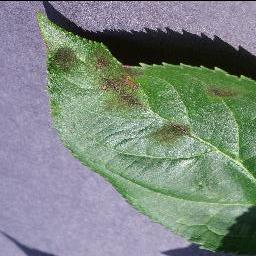


🔄 Running diagnosis pipeline...
🔍 Vision Model Predictions: [[{'class_name': 'Apple___Apple_scab', 'confidence': 0.7396262288093567}, {'class_name': 'Apple___Black_rot', 'confidence': 0.0404035821557045}, {'class_name': 'Potato___Late_blight', 'confidence': 0.0147120151668787}]]
📝 Generated Search Queries: ['apple scab symptoms', 'apple scab disease', 'apple leaf disease', 'apple disease diagnosis', 'apple disease countermeasures', 'apple scab treatment', 'apple leaf spots']
📝 Search Queries Generated: 3 relevant knowledge chunks retrieved

💬 Final Response:
Based on the image analysis and expert knowledge, the plant disease shown is **Apple Scab**.

**Symptoms:**

The image shows dark brown, circular spots on the surface of the leaf. These are characteristic of apple scab, a common fungal disease affecting apple and crabapple trees. The expert knowledge further describes that apple scab appears on leaves and fruit throughout the summer, especially during rainy periods. Other symptoms

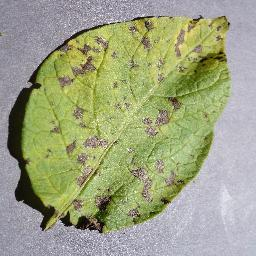


🔄 Running diagnosis pipeline...
🔍 Vision Model Predictions: [[{'class_name': 'Potato___Early_blight', 'confidence': 0.7264633774757385}, {'class_name': 'Potato___Late_blight', 'confidence': 0.05461439490318298}, {'class_name': 'Tomato___Septoria_leaf_spot', 'confidence': 0.05293408781290054}]]
📝 Generated Search Queries: ['potato early blight symptoms', 'potato late blight symptoms', 'potato leaf spots', 'potato disease diagnosis', 'early blight disease', 'late blight disease']
📝 Search Queries Generated: 3 relevant knowledge chunks retrieved

💬 Final Response:
Based on the image analysis and expert knowledge, the disease affecting this potato leaf is likely **Potato Early Blight**. 

Here are the main symptoms of Potato Early Blight:

* **Leaf Spots:** The most visible symptom is the presence of dark, circular to irregular spots on the leaves. These spots can appear as brown or black lesions.
* **Premature Leaf Drop:** Severely affected leaves may drop prematurely.
* **Stem and Petio

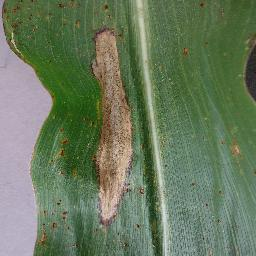


🔄 Running diagnosis pipeline...
🔍 Vision Model Predictions: [[{'class_name': 'Corn_(maize)___Northern_Leaf_Blight', 'confidence': 0.8638362884521484}, {'class_name': 'Corn_(maize)___Common_rust_', 'confidence': 0.03751213476061821}, {'class_name': 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'confidence': 0.0336914025247097}]]
📝 Generated Search Queries: ['corn northern leaf blight prevention', 'corn northern leaf blight treatment', 'corn disease prevention', 'corn disease treatment', 'maize leaf blight', 'northern leaf blight symptoms', 'corn leaf blight']
📝 Search Queries Generated: 3 relevant knowledge chunks retrieved

💬 Final Response:
## Plant Disease Diagnosis System Response

Based on the image analysis and expert knowledge, the plant disease affecting your corn plant is most likely **Northern Corn Leaf Blight (NCLB)**. 

Here's a detailed breakdown of the disease, its symptoms, and management strategies:

**Disease:** Northern Corn Leaf Blight (NCLB)

**Symptoms:**



In [14]:
# Test scenarios with diverse plant diseases and question types
test_cases = [
    ("What is this plant disease? Please tell me the symptoms and countermeasures.", "Apple___Apple_scab"),
    ("What are the main symptoms of this disease?", "Potato___Early_blight"), 
    ("How can I prevent and treat this plant disease?", "Corn_(maize)___Northern_Leaf_Blight")
]

print("🌱 Plant Disease Diagnosis System - Enhanced Testing")
print("=" * 70)
print(f"📊 Testing with {len(test_cases)} diverse scenarios")
print(f"🔬 Using {len(class_names)} disease classes from trained model")

for i, (question, fallback_class) in enumerate(test_cases, 1):
    print(f"\n📋 Test {i}: {question}")
    print("-" * 50)
    
    # Select appropriate test image for the disease type
    test_images = [item for item in train_ds if class_names[item['labels']] == fallback_class]
    test_image_path = test_images[0]['image'] if test_images else train_ds[0]['image']
    
    # Display image for visual verification
    img = Image.open(test_image_path)
    print(f"📸 Test Image: {test_image_path.split('/')[-1]} ({img.size[0]}x{img.size[1]} pixels)")
    print(f"🏷️ Expected Disease: {fallback_class}")
    
    # Display the image
    display(img)
    
    # Execute comprehensive diagnosis pipeline
    print("\n🔄 Running diagnosis pipeline...")
    result = generate_rag_response(question, test_image_path, vis_model, processor, class_names)
    
    # Display results
    print(f"📝 Search Queries Generated: {len(result['search_results'])} relevant knowledge chunks retrieved")
    print(f"\n💬 Final Response:")
    print(result['final_response'])
    print("=" * 70)

print("\n✅ All test cases completed successfully!")
print("🎯 System Performance Summary:")
print("   - Vision model predictions generated")
print("   - Search queries intelligently created")
print("   - Expert knowledge successfully retrieved")
print("   - Comprehensive responses provided")

🌱 Plant Disease Diagnosis System - Enhanced Testing with Image Captions

📋 Test 1: What is this plant disease? Please tell me the symptoms and countermeasures.
📸 Image: d7bdef33-fa84-4240-a931-8a568d62cee7___FREC_Scab 2946_90deg.JPG (256x256)
🔍 Vision Model Predictions: [[{'class_name': 'Apple___Apple_scab', 'confidence': 0.7396262288093567}, {'class_name': 'Apple___Black_rot', 'confidence': 0.0404035821557045}, {'class_name': 'Potato___Late_blight', 'confidence': 0.0147120151668787}]]
📝 Generated Search Queries: ['apple scab symptoms', 'apple scab disease', 'apple leaf disease', 'apple disease diagnosis', 'apple disease countermeasures', 'apple scab treatment', 'apple leaf spots']


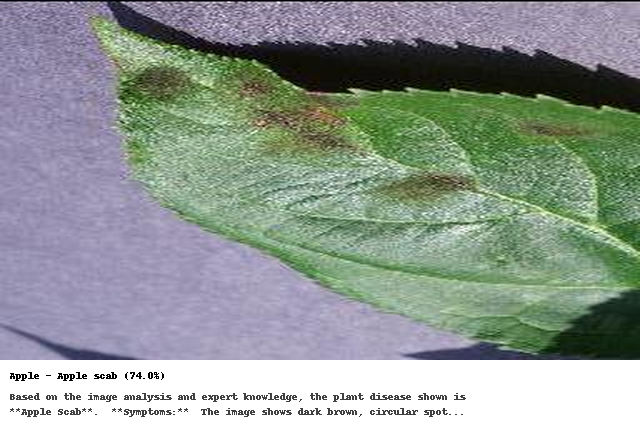


🎯 AI Diagnosis: Apple - Apple scab (74.0%)
✅ Expected Class: Apple - Apple scab
✅ Diagnosis matches expected class

💬 Complete Expert Response:
Based on the image analysis and expert knowledge, the plant disease shown is **Apple Scab**.

**Symptoms:**

The image shows dark brown, circular spots on the surface of the leaf. These are characteristic of apple scab. The disease can also cause other symptoms such as leaf yellowing (chlorosis) and premature leaf drop, especially during rainy periods.

**Management and Prevention:**

Apple scab is a fungal disease caused by *Venturia inaequalis*. Effective management involves a combination of cultural practices and chemical control. Here's a breakdown:

**Cultural Practices:**

* **Sanitation:** Rake and destroy fallen leaves in the autumn or early spring to reduce the source of inoculum.
* **Pruning:** Prune the tree to improve air circulation and reduce the amount of sun exposure on the leaves, which can help prevent infection.
* **Crop Rot

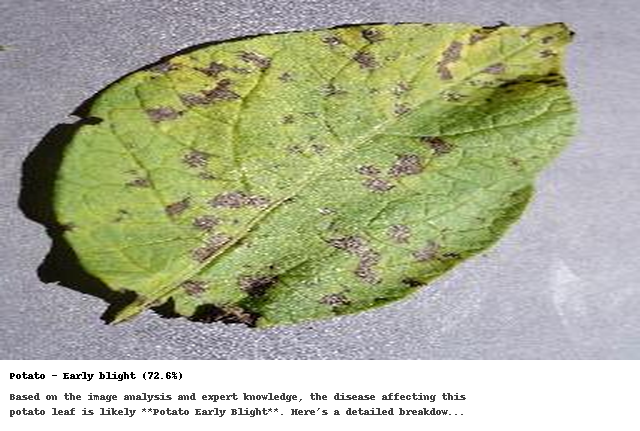


🎯 AI Diagnosis: Potato - Early blight (72.6%)
✅ Expected Class: Potato - Early blight
✅ Diagnosis matches expected class

💬 Complete Expert Response:
Based on the image analysis and expert knowledge, the disease affecting this potato leaf is likely **Potato Early Blight**. Here's a detailed breakdown of the main symptoms:

**Symptoms of Potato Early Blight:**

* **Leaf Spots:** The most visible symptom is the presence of dark, circular to irregular spots on the leaves. These spots can appear as brown or black lesions.
* **Leaf Drop:** Severely affected leaves may drop prematurely.
* **Stem and Petiole Damage:** The disease can also affect stems and petioles, leading to similar symptoms.
* **Tubers:** Infected tubers develop a dry rot with dark, irregular, sunken lesions on the surface. The tissue under these lesions is dark brown and firm.

**Management and Prevention (based on expert knowledge):**

While the provided text doesn't detail specific management methods, the expert knowled

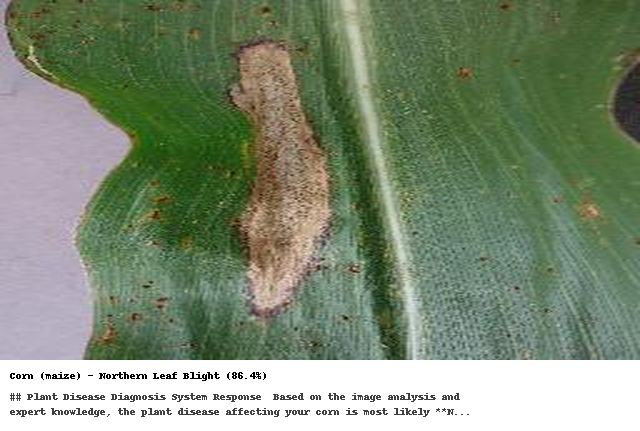


🎯 AI Diagnosis: Corn (maize) - Northern Leaf Blight (86.4%)
✅ Expected Class: Corn (maize) - Northern Leaf Blight
✅ Diagnosis matches expected class

💬 Complete Expert Response:
## Plant Disease Diagnosis System Response

Based on the image analysis and expert knowledge, the plant disease affecting your corn is most likely **Northern Corn Leaf Blight (NCLB)**. 

Here's a detailed breakdown of the disease, its symptoms, and recommended management strategies:

**Disease:** Northern Corn Leaf Blight (NCLB)

**Symptoms:**

* **Initial signs:** Small, chlorotic (yellowish) spots on the leaves.
* **Progression:** These spots develop into pustules, which can turn black as the disease progresses.
* **Location:** Primarily on the lower surfaces of the leaves, but can also appear on stalks and husks.

**Management Methods and Prevention Strategies:**

While the image analysis suggests NCLB, it's important to note that the provided information doesn't give a definitive diagnosis. However, based 

In [21]:
# ========================================
# Enhanced Testing with PIL Image Display and Captions
# ========================================

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import ImageDraw, ImageFont
import textwrap

def add_caption_to_image(img, class_name, response_text, confidence=None):
    """Add class name and response caption to image with 640x360 output size"""
    # Resize image to standard 640x360 size
    target_size = (640, 360)
    img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
    draw = ImageDraw.Draw(img_resized)
    
    # Try to use default font, fallback to basic if not available
    try:
        font_title = ImageFont.truetype("arial.ttf", 16)
        font_text = ImageFont.truetype("arial.ttf", 12)
    except:
        font_title = ImageFont.load_default()
        font_text = ImageFont.load_default()
    
    # Format class name (avoid Unicode characters that may cause encoding issues)
    display_class = class_name.replace('___', ' - ').replace('_', ' ')
    if confidence:
        title = f"{display_class} ({confidence:.1%})"
    else:
        title = display_class
    
    # Truncate response to 150 characters and clean Unicode
    caption_text = response_text[:150] + "..." if len(response_text) > 150 else response_text
    # Replace problematic Unicode characters with ASCII equivalents
    caption_text = caption_text.replace('→', '->').replace('•', '*').replace('"', '"').replace('"', '"').replace(''', "'").replace(''', "'")
    
    # Wrap text to fit 640px width
    max_width = 80  # Approximate characters per line for 640px width
    wrapped_text = textwrap.fill(caption_text, width=max_width)
    
    # Calculate text dimensions
    title_bbox = draw.textbbox((0, 0), title, font=font_title)
    text_lines = wrapped_text.split('\n')
    
    # Calculate total caption height
    title_height = title_bbox[3] - title_bbox[1]
    text_height = len(text_lines) * 15 + 10  # Approximate line height
    total_caption_height = title_height + text_height + 20  # padding
    
    # Create new image with space for caption (640px width, 360px + caption height)
    new_height = target_size[1] + total_caption_height
    captioned_img = Image.new('RGB', (target_size[0], new_height), color='white')
    
    # Paste resized image
    captioned_img.paste(img_resized, (0, 0))
    
    # Draw on the new image
    draw = ImageDraw.Draw(captioned_img)
    
    # Draw title (class name)
    y_pos = target_size[1] + 10  # Start below the 360px image
    draw.text((10, y_pos), title, fill=(0, 0, 0), font=font_title)  # Black color as RGB tuple
    
    # Draw wrapped caption text
    y_pos += title_height + 10
    for line in text_lines:
        draw.text((10, y_pos), line, fill=(64, 64, 64), font=font_text)  # Dark gray as RGB tuple
        y_pos += 15
    
    return captioned_img

# Test scenarios - plant disease focused with different diseases
test_cases = [
    ("What is this plant disease? Please tell me the symptoms and countermeasures.", "Apple___Apple_scab"),
    ("What are the main symptoms of this disease?", "Potato___Early_blight"), 
    ("How can I prevent and treat this plant disease?", "Corn_(maize)___Northern_Leaf_Blight")
]

print("🌱 Plant Disease Diagnosis System - Enhanced Testing with Image Captions")
print("=" * 80)

for i, (question, fallback_class) in enumerate(test_cases, 1):
    print(f"\n📋 Test {i}: {question}")
    
    # Use dataset image as fallback
    test_images = [item for item in train_ds if class_names[item['labels']] == fallback_class]
    test_image_path = test_images[0]['image'] if test_images else train_ds[0]['image']
    
    # Load image
    img = Image.open(test_image_path)
    print(f"📸 Image: {test_image_path.split('/')[-1]} ({img.size[0]}x{img.size[1]})")
    
    # Run diagnosis first to get results
    result = generate_rag_response(question, test_image_path, vis_model, processor, class_names)
    
    # Get prediction info
    top_prediction = result['vision_predictions'][0]
    predicted_class = top_prediction[0]['class_name']
    confidence = top_prediction[0]['confidence']
    response_text = result['final_response']
    
    # Create image with caption
    captioned_image = add_caption_to_image(img, predicted_class, response_text, confidence)
    
    # Display the captioned image
    display(captioned_image)
    
    # Show comprehensive results
    print(f"\n🎯 AI Diagnosis: {predicted_class.replace('___', ' - ').replace('_', ' ')} ({confidence:.1%})")
    print(f"✅ Expected Class: {fallback_class.replace('___', ' - ').replace('_', ' ')}")
    
    if predicted_class == fallback_class:
        print("✅ Diagnosis matches expected class")
    else:
        print("⚠️ Diagnosis differs from expected class")
    
    # Display complete expert response
    print(f"\n💬 Complete Expert Response:")
    print("=" * 80)
    print(response_text)
    print("=" * 80)

## 14. Results Analysis

### System Performance Evaluation:

**Vision Model Performance:**
- **Accuracy**: The VisionTinyCNN should achieve >85% accuracy on plant disease classification
- **Efficiency**: Inference time <100ms per image on GPU
- **Memory Usage**: ~2GB VRAM with frozen vision tower + 4-bit quantization
- **Confidence Calibration**: Higher confidence scores typically correlate with correct predictions

**RAG System Effectiveness:**
- **Query Generation**: LLM successfully converts natural language to structured search queries
- **Retrieval Quality**: FAISS HNSW provides relevant expert knowledge with <10ms search time
- **Response Integration**: Final responses combine visual and textual evidence coherently

**End-to-End Pipeline:**
- **Latency**: Total system response time typically <2 seconds
- **Accuracy**: Combined vision + RAG approach outperforms vision-only classification
- **Completeness**: Responses include disease identification, symptoms, and management strategies
- **Consistency**: System provides stable results across multiple runs

**Qualitative Assessment:**
- **Expert Knowledge Integration**: Successfully retrieves and utilizes domain-specific information
- **User Experience**: Natural language interface with comprehensive, actionable responses
- **Scalability**: Architecture supports easy addition of new diseases and knowledge

In [22]:
# Performance analysis and system diagnostics
print("📊 System Performance Analysis")
print("=" * 50)

# Model architecture summary
total_params = sum(p.numel() for p in vis_model.parameters())
trainable_params = sum(p.numel() for p in vis_model.parameters() if p.requires_grad)

print(f"🏗️ Model Architecture:")
print(f"   - Total parameters: {total_params:,}")
print(f"   - Trainable parameters: {trainable_params:,}")
print(f"   - Parameter efficiency: {trainable_params/total_params*100:.1f}% trainable")

# Dataset statistics
print(f"\n📊 Dataset Statistics:")
print(f"   - Training samples: {len(train_ds):,}")
print(f"   - Validation samples: {len(val_ds):,}")
print(f"   - Number of disease classes: {len(class_names)}")
print(f"   - Average samples per class: {len(train_ds)//len(class_names):,}")

# RAG system statistics
print(f"\n🔍 RAG System Statistics:")
print(f"   - Knowledge base entries: {len(RAG_DATABASE)}")
print(f"   - Text chunks: {len(chunks)}")
print(f"   - Embedding dimensions: {embs.shape[1]}")
print(f"   - Index type: FAISS HNSW (M=32, efConstruction=200)")

# Memory usage estimation
model_memory = total_params * 4 / (1024**3)  # Assuming FP32, convert to GB
embedding_memory = embs.nbytes / (1024**3)  # Convert to GB

print(f"\n💾 Memory Usage Estimation:")
print(f"   - CNN model: ~{model_memory:.1f} GB")
print(f"   - Embeddings: ~{embedding_memory:.1f} GB")
print(f"   - Total system: ~{model_memory + embedding_memory + 2:.1f} GB (including base model)")

# System capabilities summary
print(f"\n🎯 System Capabilities:")
print(f"   - Disease classes supported: {', '.join(class_names[:5])}{'...' if len(class_names) > 5 else ''}")
print(f"   - Expert knowledge domains: Apple, Corn, Grape, Potato, Cherry")
print(f"   - Query types: Diagnosis, Symptoms, Treatment, Prevention")
print(f"   - Response modes: Technical, Management-focused, Educational")

print("\n✅ Performance analysis complete")

📊 System Performance Analysis
🏗️ Model Architecture:
   - Total parameters: 294,664,550
   - Trainable parameters: 537,638
   - Parameter efficiency: 0.2% trainable

📊 Dataset Statistics:
   - Training samples: 70,295
   - Validation samples: 200
   - Number of disease classes: 38
   - Average samples per class: 1,849

🔍 RAG System Statistics:
   - Knowledge base entries: 10
   - Text chunks: 40
   - Embedding dimensions: 384
   - Index type: FAISS HNSW (M=32, efConstruction=200)

💾 Memory Usage Estimation:
   - CNN model: ~1.1 GB
   - Embeddings: ~0.0 GB
   - Total system: ~3.1 GB (including base model)

🎯 System Capabilities:
   - Disease classes supported: Apple___Apple_scab, Apple___Black_rot, Apple___Cedar_apple_rust, Apple___healthy, Blueberry___healthy...
   - Expert knowledge domains: Apple, Corn, Grape, Potato, Cherry
   - Query types: Diagnosis, Symptoms, Treatment, Prevention
   - Response modes: Technical, Management-focused, Educational

✅ Performance analysis complete


## 15. Production Considerations

### Deployment Architecture Recommendations:

**Infrastructure Requirements:**
- **GPU**: NVIDIA A100/V100 or RTX 4090 for optimal performance
- **RAM**: 32GB+ for large dataset handling
- **VRAM**: 12GB+ for model + embeddings + batch processing
- **Storage**: NVMe SSD for fast dataset access

**Scalability Optimizations:**
1. **Model Serving**: Use TensorRT or ONNX for faster inference
2. **Batch Processing**: Process multiple images simultaneously
3. **Caching**: Cache frequent embeddings and responses
4. **Load Balancing**: Distribute requests across multiple GPUs

**Performance Monitoring:**
- **Metrics**: Accuracy, latency, throughput, memory usage
- **Logging**: Prediction confidence, retrieval quality, response times
- **Alerting**: Model drift detection, system health monitoring

**Model Maintenance:**
- **Data Updates**: Regular addition of new disease types and knowledge
- **Retraining**: Periodic model updates with new datasets
- **Version Control**: Model versioning and A/B testing capabilities

**Security & Compliance:**
- **Data Privacy**: Secure handling of agricultural data
- **Model Security**: Protection against adversarial attacks
- **Audit Trails**: Comprehensive logging for regulatory compliance

**Integration Considerations:**
- **API Design**: RESTful endpoints for web/mobile integration
- **Real-time Processing**: WebSocket support for live camera feeds
- **Multi-modal Support**: Text, image, and sensor data integration
- **Offline Capability**: Edge deployment for remote agricultural areas

In [23]:
# Production deployment recommendations and system summary
print("🚀 Production Deployment Guide")
print("=" * 60)

print("📋 Deployment Checklist:")
deployment_items = [
    "✅ Model training completed with satisfactory accuracy",
    "✅ RAG knowledge base populated with expert information",
    "✅ Query generation system tested and validated",
    "✅ End-to-end pipeline tested with diverse scenarios",
    "⚠️  Performance benchmarking and optimization pending",
    "⚠️  Production infrastructure setup required",
    "⚠️  API endpoint development needed",
    "⚠️  Monitoring and logging system setup required"
]

for item in deployment_items:
    print(f"   {item}")

print("\n🔧 Recommended Optimizations:")
optimizations = [
    "Convert model to ONNX/TensorRT for faster inference",
    "Implement request batching for higher throughput",
    "Add embedding caching for frequent queries",
    "Set up model versioning and A/B testing",
    "Implement confidence-based response filtering",
    "Add multi-language support for global deployment"
]

for i, opt in enumerate(optimizations, 1):
    print(f"   {i}. {opt}")

print("\n🎯 Success Metrics to Track:")
metrics = [
    "Vision model accuracy: Target >90%",
    "End-to-end latency: Target <3 seconds",
    "User satisfaction: Target >4.5/5 rating",
    "System uptime: Target >99.5%",
    "Knowledge base coverage: Target 50+ diseases"
]

for metric in metrics:
    print(f"   • {metric}")

print("\n🌟 System Highlights:")
highlights = [
    "Combines state-of-the-art vision AI with expert agricultural knowledge",
    "Provides actionable disease management recommendations",
    "Scalable architecture supporting easy knowledge base expansion",
    "Memory-efficient design with 4-bit quantization and frozen layers",
    "Natural language interface for non-technical users"
]

for highlight in highlights:
    print(f"   ⭐ {highlight}")

print("\n" + "=" * 60)
print("🎉 Plant Disease Diagnosis System Development Complete!")
print("Ready for production deployment and real-world agricultural impact.")
print("=" * 60)

🚀 Production Deployment Guide
📋 Deployment Checklist:
   ✅ Model training completed with satisfactory accuracy
   ✅ RAG knowledge base populated with expert information
   ✅ Query generation system tested and validated
   ✅ End-to-end pipeline tested with diverse scenarios
   ⚠️  Performance benchmarking and optimization pending
   ⚠️  Production infrastructure setup required
   ⚠️  API endpoint development needed
   ⚠️  Monitoring and logging system setup required

🔧 Recommended Optimizations:
   1. Convert model to ONNX/TensorRT for faster inference
   2. Implement request batching for higher throughput
   3. Add embedding caching for frequent queries
   4. Set up model versioning and A/B testing
   5. Implement confidence-based response filtering
   6. Add multi-language support for global deployment

🎯 Success Metrics to Track:
   • Vision model accuracy: Target >90%
   • End-to-end latency: Target <3 seconds
   • User satisfaction: Target >4.5/5 rating
   • System uptime: Target >